In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import arrow
from pathlib import Path
import netCDF4 as nc
from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm as cm
import pandas as pd
import datetime as dt

In [2]:
# Obs cordonates (Saanich Inlet) : 48.651366°N, -123.486358°W, 93m
# Obs cordonates: SoG Center: 49.039467°N, -123.425033°W, 305m ; SoG Est: 49.042586°N,  -123.316579°W, 166m
df_rko = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/SI_Venus_Inst_Platform/Rinko_Oxygen_20180101_20201231_SI_edit.csv')
df_sog = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/O2Sensor_Oxygen_20180101_20201231_SoGC_edit.csv')

In [3]:
# Convert objet dataframe to int
df_sog['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_sog['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_rko['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_rko['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
# Obs variables
oxy_sog = df_sog['Oxygen Concentration Corrected (ml/l)']
oxy_saa = df_rko['Oxygen Concentration Corrected (ml/l)']
time = np.arange(dt.datetime(2018,1,1), dt.datetime(2020,12,31), dt.timedelta(days=1)).astype(dt.datetime)


In [4]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
tmask = meshmask.tmask
mbathy = meshmask.mbathy

mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202310b.nc')
thalweg_SI = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/SaanichInlet_thalweg.txt' 
thalweg_HC = '/ocean/atall/MOAD/analysis-abdoul/thalweg_files/HoodCanal_thalweg.txt' 
thalweg_SoG = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_ptsSI = np.loadtxt(thalweg_SI, delimiter=' ', dtype=int)
thalweg_ptsHC = np.loadtxt(thalweg_HC, delimiter=' ', dtype=int)
thalweg_ptsSoG = np.loadtxt(thalweg_SoG, delimiter=' ', dtype=int)
depth = mesh.variables['gdept_0'][:]


In [5]:
jj_saa = grid_lons_lats.jj.sel(lats=48.651366, lons=-123.486358, method='nearest') # 93 m (Obs)
ii_saa = grid_lons_lats.ii.sel(lats=48.651366, lons=-123.486358, method='nearest')
jj_sog = grid_lons_lats.jj.sel(lats=49.039467, lons=-123.425033, method='nearest') # 305 m (Obs)
ii_sog = grid_lons_lats.ii.sel(lats=49.039467, lons=-123.425033, method='nearest')
print((jj_saa.item(),ii_saa.item()), (jj_sog.item(),ii_sog.item()))

(353, 209) (423, 266)


#### Spring/Neap tide periods at Patricia Bay

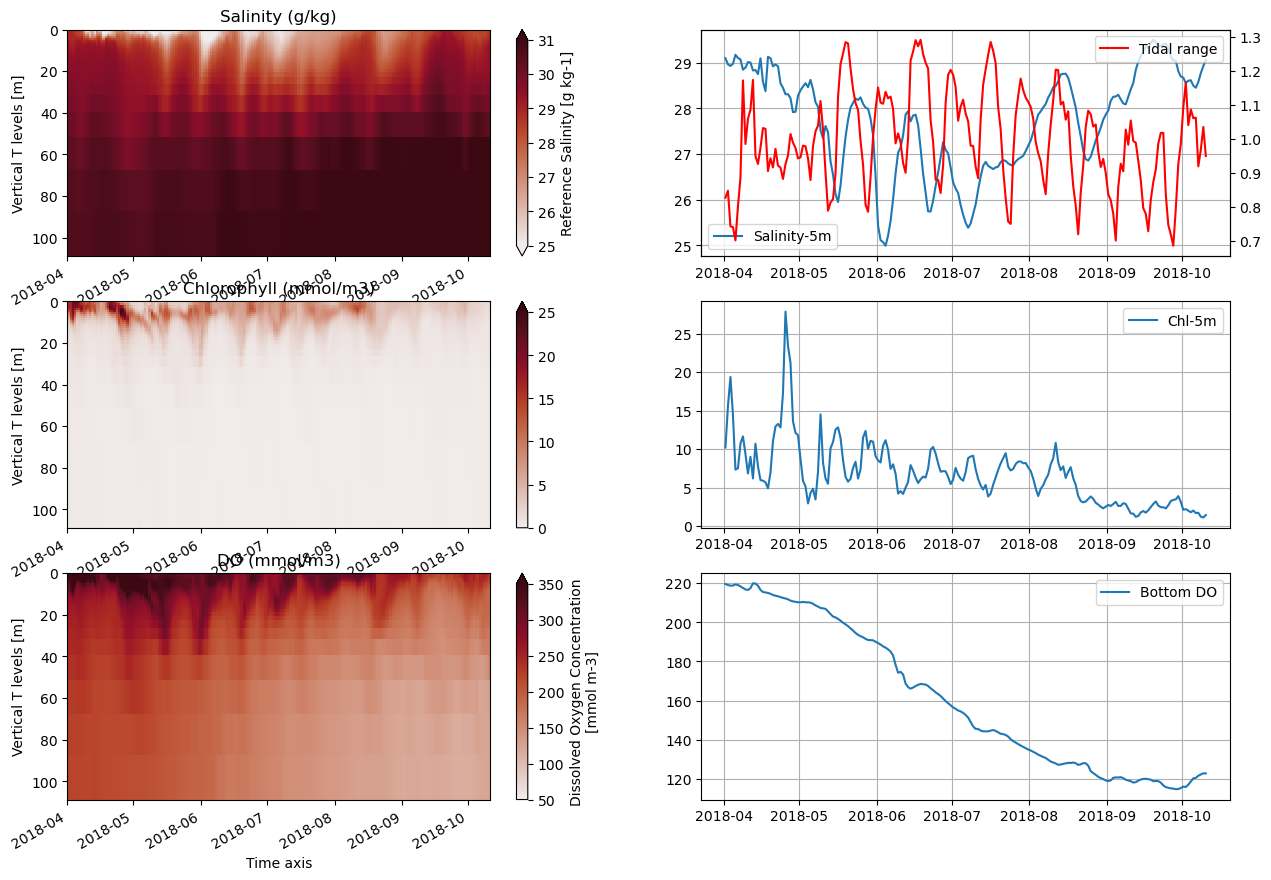

In [9]:
syear = 2018
eyear = 2018
smonth = 4
emonth = 10
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 10)
line, col = (3, 1)
fig, axs = plt.subplots(line, 2, figsize=(5*line, 10*col))
title = list(['Salinity (g/kg)','Chlorophyll (mmol/m3)','DO (mmol/m3)'])
dir = '/ocean/sallen/timbucktwo/oxygen/'
#dir = '/ocean/atall/MOAD/Model/runs/salishsea_oxy/diagnosticsO2/withZ2param/'
dirssh = '/results2/SalishSea/nowcast-green.202111/'
for ii in range(0, col):
    if ii==0:
        KK, JJ, II = (27, jj_saa, ii_saa)
    else:
        KK, JJ, II = (22, 72, 123) #Hood Canal, Twanoh
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fgrdtssh = f'{dirssh}{day:02}{Month}{yr2}/SalishSea_1h_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
        with xr.open_dataset(fgrdtssh) as ds_grdtssh:
            ssh0 = np.max(ds_grdtssh['sossheig'][:,JJ,II])#-np.mean(ds_grdtssh['sossheig'][:,JJ,II])
        fgrdt = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
        with xr.open_dataset(fgrdt) as ds_grdt:
            sal0 = ds_grdt['vosaline'][:,:KK,JJ,II]
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen'][:,:KK,JJ,II]
        fbiol = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
        with xr.open_dataset(fbiol) as ds_biol:
            nit0 = ds_biol['nitrate'][:,:KK,JJ,II]
            dia0 = ds_biol['diatoms'][:,:KK,JJ,II]
            fla0 = ds_biol['flagellates'][:,:KK,JJ,II]
        if first:
            first = False
            nit = nit0
            fla = fla0
            dia = dia0
            ssh = ssh0
            sal = sal0
            oxy = oxy0
        else:
            nit = xr.concat([nit, nit0], dim='time_counter')
            dia = xr.concat([dia, dia0], dim='time_counter')
            fla = xr.concat([fla, fla0], dim='time_counter')
            sal = xr.concat([sal, sal0], dim='time_counter')
            ssh = xr.concat([ssh, ssh0], dim='time_counter')
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
    
    for jj  in range(0, line):
        cmap = cm.balance
        if jj==0:
            vars = sal
            cmap = cm.amp
            vmin, vmax=(25, 31)
            vars.plot(ax=axs[jj,0], y="deptht",yincrease=False, vmin=vmin, vmax=vmax, cmap=cmap);
            axs[jj,1].plot(sal.time_counter, sal[:,5], label='Salinity-5m');
            ax2 = axs[jj,1].twinx()
            ax2.plot(sal.time_counter, ssh, color='r',label='Tidal range');
            
            axs[jj,1].legend()
            ax2.legend()
        elif jj==1:
            vars=(fla+dia)*2.5
            cmap = cm.amp
            vmin, vmax=(0, 25)
            vars.plot(ax=axs[jj,0], y="deptht",yincrease=False, vmin=vmin, vmax=vmax, cmap=cmap);
            axs[jj,1].plot(sal.time_counter, vars[:,5], label='Chl-5m');
            axs[jj,1].legend()
            axs[jj,1].set
        elif jj==2:
            vars = oxy
            cmap = cm.amp
            vmin, vmax=(50, 350)
            vars.plot(ax=axs[jj,0], y="deptht",yincrease=False, vmin=vmin, vmax=vmax, cmap=cmap);
            axs[jj,1].plot(sal.time_counter, vars[:,26],label='Bottom DO');
            axs[jj,1].legend()
        elif jj==3:
            vars=nit
            cmap = cm.amp
            vmin, vmax=(0, 15)
            vars.plot(ax=axs[jj], y="deptht",yincrease=False, vmin=vmin, vmax=vmax, cmap=cmap);
        axs[jj,0].set_title(f'{title[jj]}')
        axs[jj,1].grid()



### Advection and Vert. Diffusion at central node 

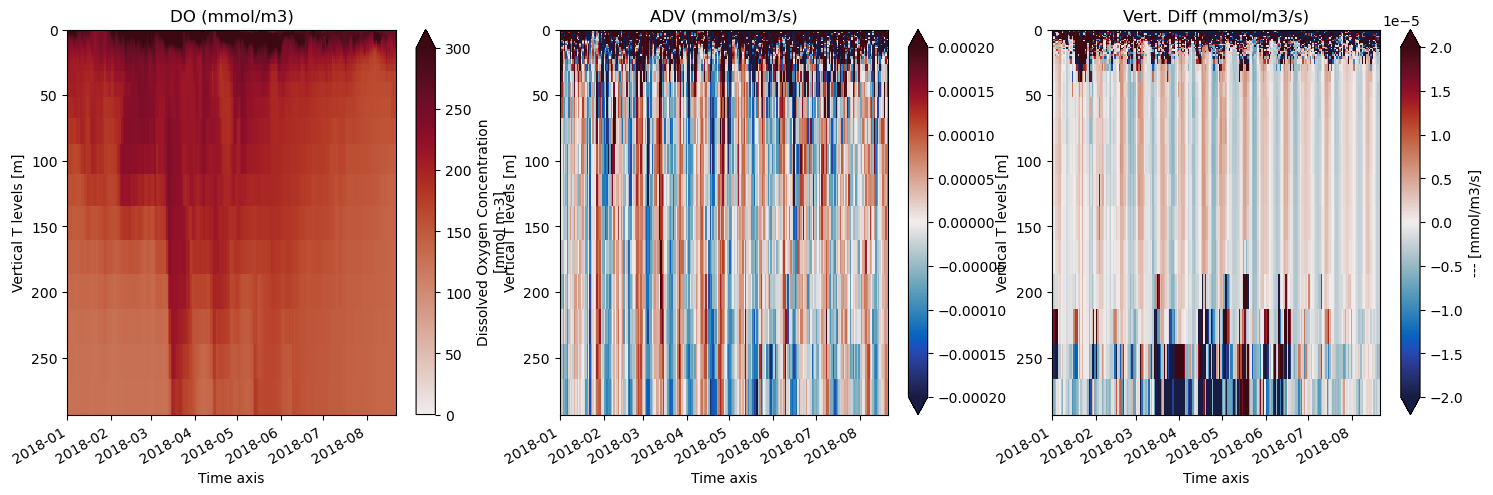

In [27]:
syear = 2018
eyear = 2018
smonth = 1
emonth = 8
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 20)
line, col = (1, 3)
fig, axs = plt.subplots(line, col, figsize=(6*col, 5*line))
#title = list(['DO','Salinity','NO3','NH4','PON','DON'])
title = list(['DO (mmol/m3)','ADV (mmol/m3/s)','Vert. Diff (mmol/m3/s)'])
dir = '/ocean/sallen/timbucktwo/oxygen/'
#dir = '/ocean/atall/MOAD/Model/runs/salishsea_oxy/diagnosticsO2/withZ2param/'
for ii in range(0, line):
    if ii==0:
        KK, JJ, II = (34, jj_sog, ii_sog)
    elif ii==1:
        KK, JJ, II = (27, jj_saa, ii_saa)
    else:
        KK, JJ, II = (22, 72, 123) #Hood Canal, Twanoh
    first = True
    for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
        year = day.year
        yr2 = day.strftime("%y")
        month = day.month
        Month = day.strftime("%b").lower()
        day = day.day
        # set up filename to follow NEMO conventions
        fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
        with xr.open_dataset(fchem) as ds_chem:
            oxy0 = ds_chem['dissolved_oxygen'][:,:KK,JJ,II]
        fgrdu = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_U.nc'
        with xr.open_dataset(fgrdu) as ds_grdu:
            u0 = ds_grdu['vozocrtx'][:,:KK,JJ,II]
        fgrdv = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_V.nc'
        with xr.open_dataset(fgrdv) as ds_grdv:
            v0 = ds_grdv['vomecrty'][:,:KK,JJ,II]
        fgrdw = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_W.nc'
        with xr.open_dataset(fgrdw) as ds_grdw:
            w0 = ds_grdw['vovecrtz'][:,:KK,JJ,II]
        fdiag = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc'
        with xr.open_dataset(fdiag) as ds_diag:
            rat0 = ds_diag['RATE_O2'][:,:KK,JJ,II]
            bio0 = ds_diag['BIO_O2'][:,:KK,JJ,II]
            xad0 = ds_diag['XAD_O2'][:,:KK,JJ,II]
            yad0 = ds_diag['YAD_O2'][:,:KK,JJ,II]
            zad0 = ds_diag['ZAD_O2'][:,:KK,JJ,II]
            ldf0 = ds_diag['LDF_O2'][:,:KK,JJ,II]
            zdf0 = ds_diag['ZDF_O2'][:,:KK,JJ,II]
            rem0 = ds_diag['REM_O2'][:,:KK,JJ,II]
            prd0 = ds_diag['PRD_O2'][:,:KK,JJ,II]
            msz0 = ds_diag['MSZ_O2'][:,:KK,JJ,II]
            miz0 = ds_diag['MIZ_O2'][:,:KK,JJ,II]
            mrt0 = ds_diag['MRT_O2'][:,:KK,JJ,II]
        if first:
            first = False
            u = u0
            v = v0
            w = w0
            oxy = oxy0
            rat = rat0
            bio = bio0
            xad = xad0
            yad = yad0
            zad = zad0
            ldf = ldf0
            zdf = zdf0
            rem = rem0
            prd = prd0
            msz = msz0
            miz = miz0
            mrt = mrt0
        else:
            u = xr.concat([u, u0], dim='time_counter')
            v = xr.concat([v, v0], dim='time_counter')
            w = xr.concat([w, w0], dim='time_counter')
            oxy = xr.concat([oxy, oxy0], dim='time_counter')
            rat = xr.concat([rat, rat0], dim='time_counter')
            bio = xr.concat([bio, bio0], dim='time_counter')
            xad = xr.concat([xad, xad0], dim='time_counter')
            yad = xr.concat([yad, yad0], dim='time_counter')
            zad = xr.concat([zad, zad0], dim='time_counter')
            ldf = xr.concat([ldf, ldf0], dim='time_counter')
            zdf = xr.concat([zdf, zdf0], dim='time_counter')
            rem = xr.concat([rem, rem0], dim='time_counter')
            prd = xr.concat([prd, prd0], dim='time_counter')
            msz = xr.concat([msz, msz0], dim='time_counter')
            miz = xr.concat([miz, miz0], dim='time_counter')
            mrt = xr.concat([mrt, mrt0], dim='time_counter')
    
    for jj  in range(0, col):
        cmap = cm.balance
        if jj==0:
            vars = oxy
            cmap = cm.amp
            vmin, vmax=(0, 300)
        elif jj==1:
            vars=xad+yad+zad
            vmin, vmax=(-0.0002, 0.0002)
        elif jj==2:
            vars=zdf
            vmin, vmax=(-0.00002, 0.00002)
        
        vars.plot(ax=axs[jj], y="deptht",yincrease=False, vmin=vmin, vmax=vmax, cmap=cmap);
        axs[jj].set_title(f'{title[jj]}')


#fig.suptitle(f'{startdate}-{enddate}: without Z2 eff, mortality & excretion')


### Bottom O2 budget : Saanich Inlet-Patricia Bay & SoG-Central node

2018-01-01T00:00:00+00:00 2018-10-05T00:00:00+00:00  : v202111
2018-01-01T00:00:00+00:00 2018-09-30T00:00:00+00:00  : Nitrif Eq corrected, PON to DON, Diat ref 0.5
2018-01-01T00:00:00+00:00 2018-10-08T00:00:00+00:00  : Nitrif Eq corrected, PON to DON, Diat ref 0.5, Z2eff=0.7, Z2Mrt&Exc used


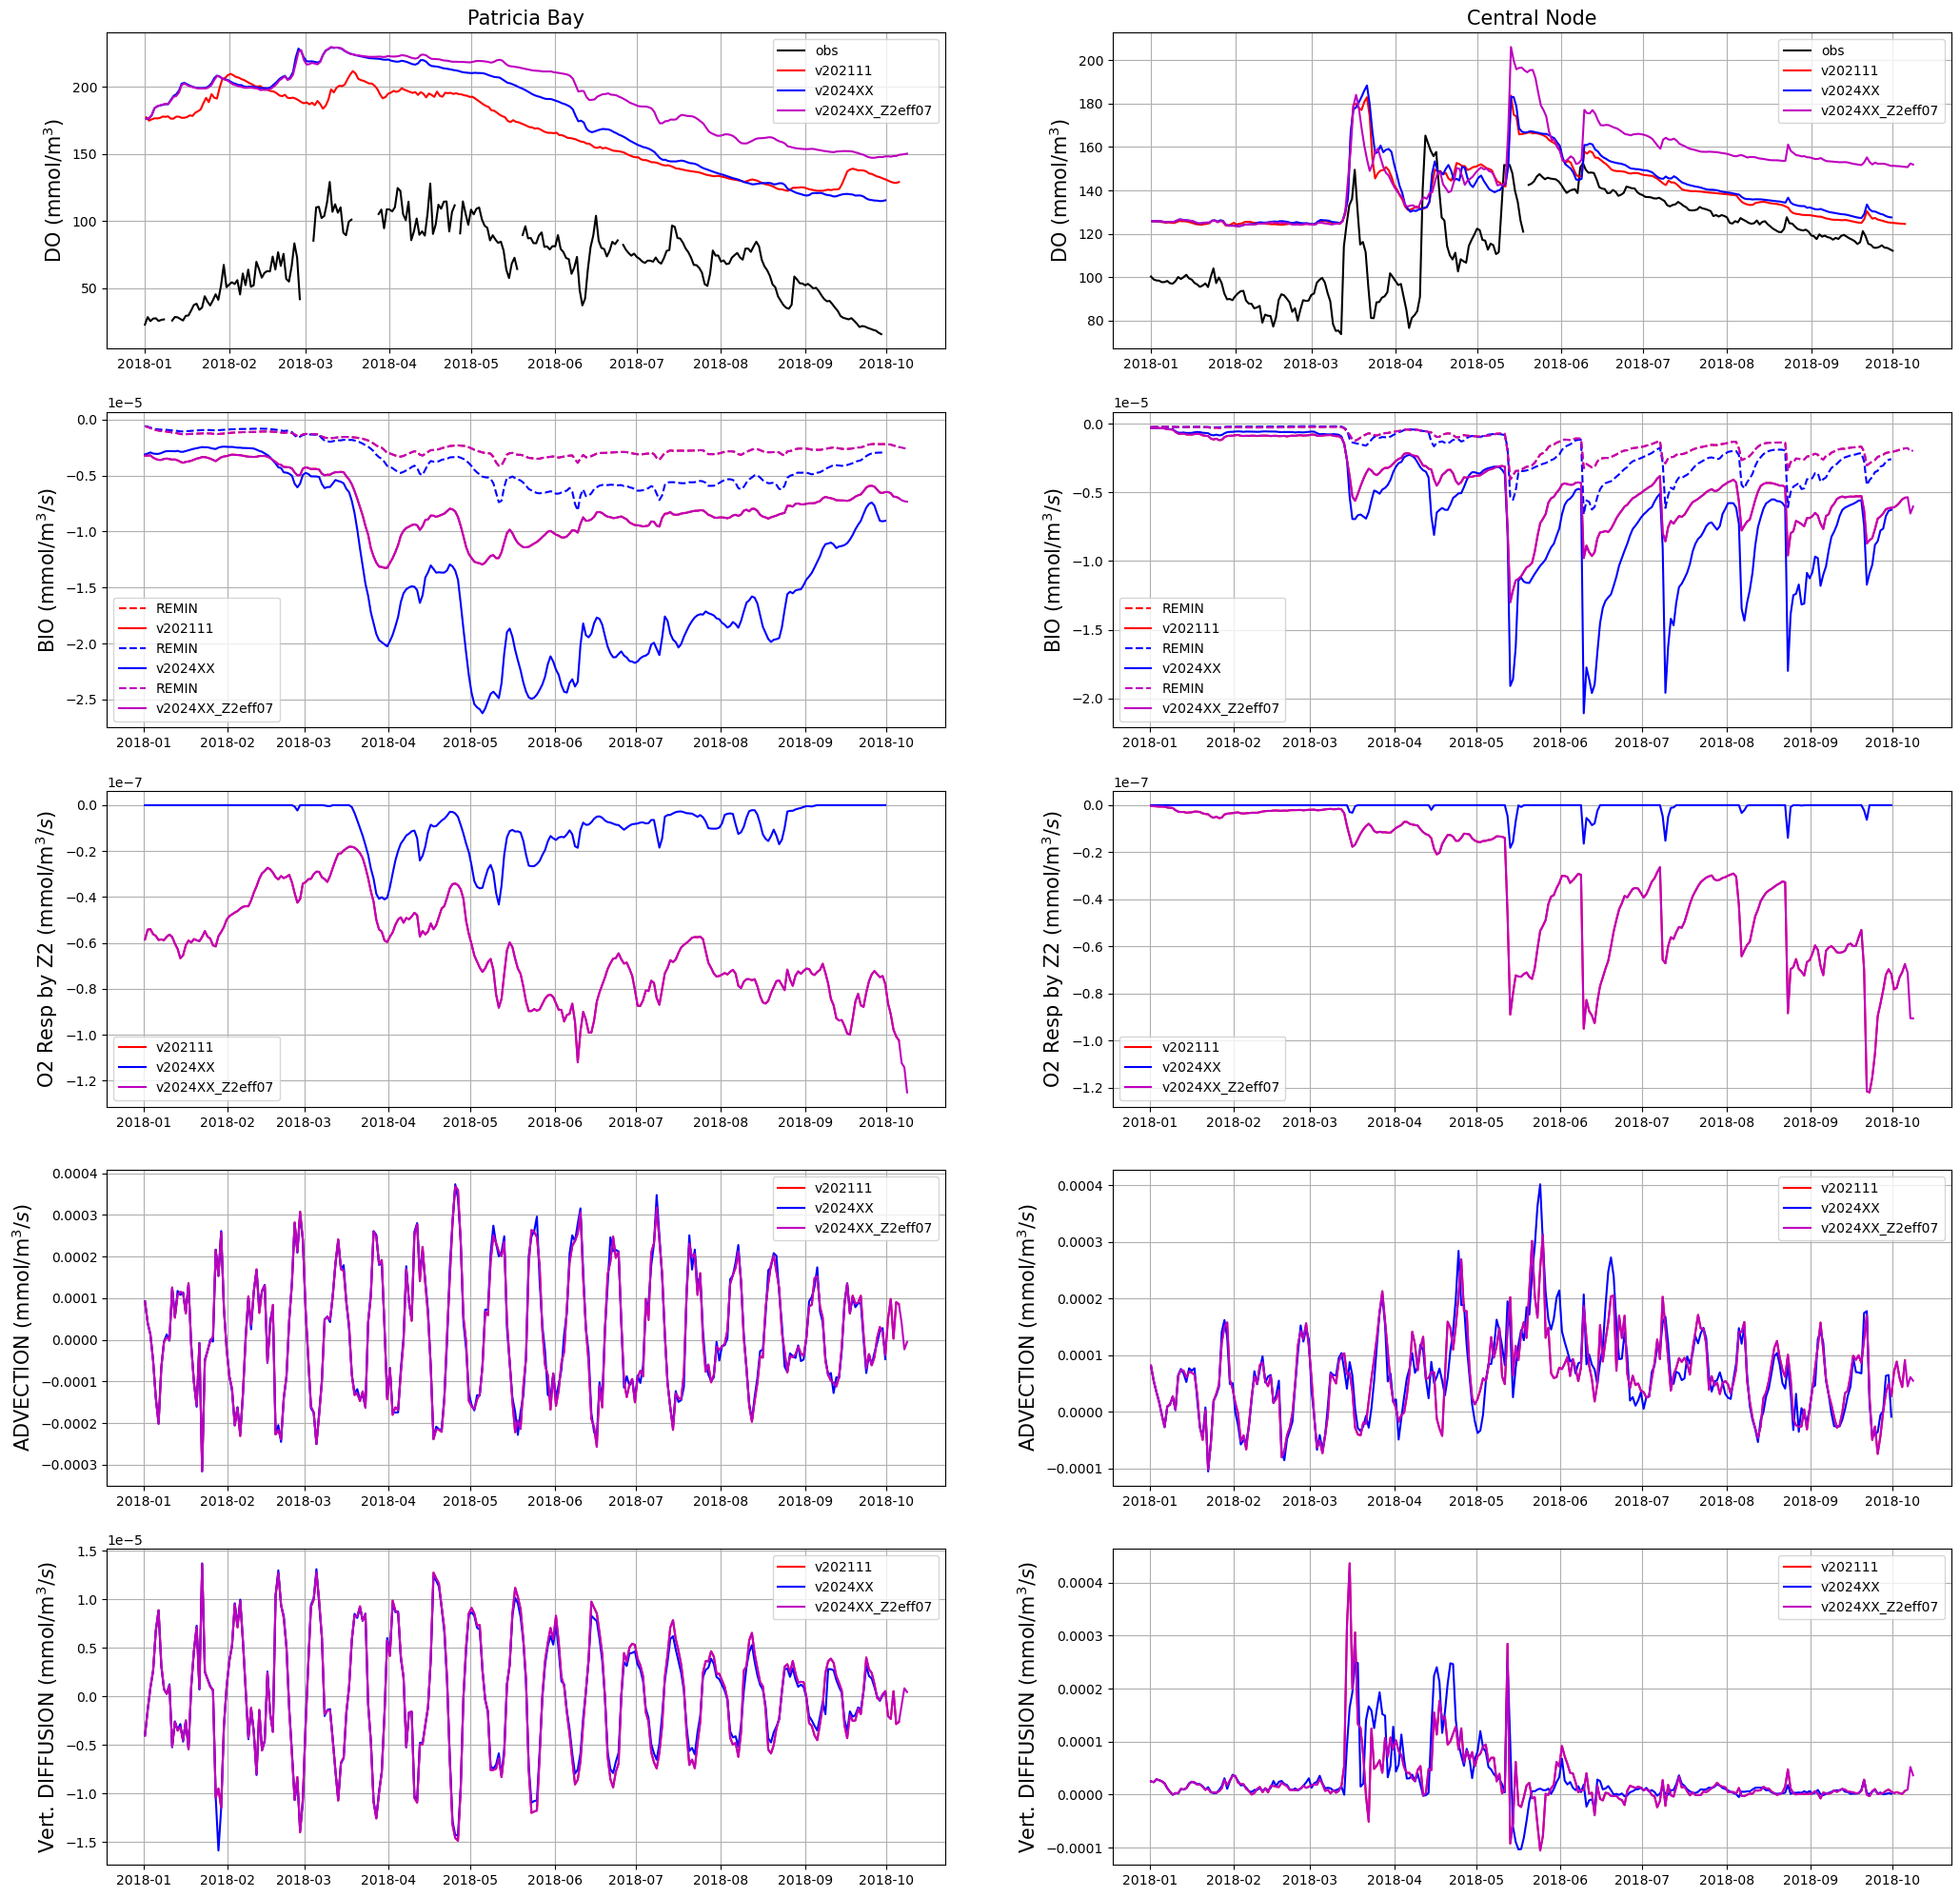

In [28]:
line, col = (5, 2)
fig, ax = plt.subplots(line, col, figsize=(25, 25))
ylabel = list(['DO (mmol/m$^3$)','BIO (mmol/m$^3/s$)','O2 Resp by Z2 (mmol/m$^3/s$)','ADVECTION (mmol/m$^3/s$)','Vert. DIFFUSION (mmol/m$^3/s$)'])
place = list(['Patricia Bay','Central Node'])
ax[0,0].plot(time[:275],oxy_saa[:275] * 44.661, 'k',label='obs')
ax[0,1].plot(time[:275],oxy_sog[:275] * 44.661, 'k', label='obs')
syear = 2018
for alpha in range(0, 3):
    if alpha == 0:
        dir = '/results2/SalishSea/nowcast-green.202111/'
        dir2 = '/ocean/atall/MOAD/Model/runs/salishsea_oxy/diagnosticsO2/withZ2param/'
        colors = 'r'
        labels = 'v202111'
        eyear = 2018
        smonth = 1
        emonth = 10
        startdate = arrow.get(syear, smonth, 1)
        enddate = arrow.get(eyear, emonth, 5)
        print (startdate, enddate,' : v202111')
    elif alpha==1:
        dir = '/ocean/sallen/timbucktwo/oxygen/'
        dir2 = dir
        colors = 'b'
        labels = 'v2024XX'
        eyear = 2018
        smonth = 1
        emonth = 9
        startdate = arrow.get(syear, smonth, 1)
        enddate = arrow.get(eyear, emonth, 30)
        print (startdate, enddate,' : Nitrif Eq corrected, PON to DON, Diat ref 0.5')
    else:
        dir = '/ocean/atall/MOAD/Model/runs/salishsea_oxy/diagnosticsO2/withZ2param/'
        dir2 = dir
        colors = 'm'
        labels = 'v2024XX_Z2eff07'
        eyear = 2018
        smonth = 1
        emonth = 10
        startdate = arrow.get(syear, smonth, 1)
        enddate = arrow.get(eyear, emonth, 8)
        print (startdate, enddate,' : Nitrif Eq corrected, PON to DON, Diat ref 0.5, Z2eff=0.7, Z2Mrt&Exc used')
        
    for j in range(0, col):
        if j==0:
            jj, ii = (jj_saa, ii_saa)
        else:
            jj, ii = (jj_sog, ii_sog)
        first = True
        for iii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
            year = day.year
            yr2 = day.strftime("%y")
            month = day.month
            Month = day.strftime("%b").lower()
            day = day.day
            # set up filename to follow NEMO conventions
            fchem = f'{dir}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
            with xr.open_dataset(fchem) as ds_chem:
                oxy0 = ds_chem['dissolved_oxygen'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            fdiag = f'{dir2}{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_diag_T.nc'
            with xr.open_dataset(fdiag) as ds_diag:
                xad0 = ds_diag['XAD_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                yad0 = ds_diag['YAD_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                zad0 = ds_diag['ZAD_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                zdf0 = ds_diag['ZDF_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                rem0 = ds_diag['REM_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                bio0 = ds_diag['BIO_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
                msz0 = ds_diag['MSZ_O2'][0, mbathy[0, jj, ii]-1, jj, ii].where(tmask[0, mbathy[0, jj, ii]-1, jj, ii] == 1)
            if first:
                first = False
                oxy = oxy0
                xad = xad0
                yad = yad0
                zad = zad0
                zdf = zdf0
                rem = rem0
                bio = bio0
                msz = msz0
            else:
                oxy = xr.concat([oxy, oxy0], dim='time_counter')
                xad = xr.concat([xad, xad0], dim='time_counter')
                yad = xr.concat([yad, yad0], dim='time_counter')
                zad = xr.concat([zad, zad0], dim='time_counter')
                zdf = xr.concat([zdf, zdf0], dim='time_counter')
                rem = xr.concat([rem, rem0], dim='time_counter')
                bio = xr.concat([bio, bio0], dim='time_counter')
                msz = xr.concat([msz, msz0], dim='time_counter')
        for i in range(0, line):
            if i==0:
                var = oxy
            elif i==1:
                var = bio
                ax[i,j].plot(rem.time_counter, rem, color=colors, linestyle='dashed', label='REMIN')
            elif i==2:
                var = msz
            elif i==3:
                var = xad+yad+zad
            elif i==4:
                var = zdf

            ax[i,j].plot(var.time_counter, var, color=colors, label=labels)
            ax[i,j].legend()
            ax[i,j].set_ylabel(f'{ylabel[i]}',fontsize=15)
            ax[0,j].set_title(f'{place[j]}',fontsize=15)
            ax[i,j].grid()